In [1]:
import pandas
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
#from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
def camera_calibration(image_folder):
    nx = 9
    ny = 6
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    image_points = []
    object_points = []
    for file_name in os.listdir(image_folder):
        file_loc = image_folder + '/' + file_name
        img = cv2.imread(file_loc)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        
        
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret:
            image_points.append(corners)
            object_points.append(objp)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1], None, None)
    
    if ret:
        with open('calibration.p', 'wb') as handle:
            pickle.dump({'mtx': mtx, 'dist': dist, 'rvecs':rvecs, 'tvecs': tvecs}, handle)
        return 0
    else:
        return 1

In [3]:
def cal_undistort(img, calibration_data = 'calibration.p'):
    with open(calibration_data, 'rb') as handle:
        b = pickle.load(handle)
        
    mtx = b['mtx']
    dist = b['dist']

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [4]:
def binarize(img, s_thresh=(120, 255), sx_thresh=(20, 255),l_thresh=(40,255)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    channels = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
#     binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return  binary


In [5]:
def tranform_image(image, inverse = False):
    src = np.float32([[226, 700],
       [1079, 700],
       [684, 450],
       [593, 450]])
    
    dst = np.float32([[226, 710],
       [1079, 710],
       [1079, 100],
       [226, 100]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    img_size = (image.shape[1],image.shape[0])
    
    output = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
        
    return output, Minv

In [6]:
def find_lanes_pixels_from_scratch(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
#     plt.figure()
#     plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])

    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    ratio = 3.7/(rightx_base - leftx_base)
    
    car_pos = ratio * (np.mean([leftx_base, rightx_base]) - midpoint)
    # Choose the number of sliding windows
    nwindows = 9


    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
#     print(window_height)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base


    # Set the width of the windows +/- margin
    margin = 125
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    return leftx, lefty, rightx, righty, car_pos

In [7]:
def find_lane_pixels_with_fit(binary_wraped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

In [8]:
def find_curve(leftx, lefty, rightx, righty):

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    x_left = [x * (3.7/700.) for x in leftx]
    y_left = [x * (30/720.) for x in lefty]
    
    x_right = [x * (3.7/700.) for x in rightx]
    y_right = [x * (30/720.) for x in righty]
    
    curve_left = np.polyfit(y_left, x_left, 2)
    curve_right = np.polyfit(y_right, x_right, 2)
    
    left_curverad = ((1 + (2*curve_left[0]*np.max(lefty) + curve_left[1])**2)**1.5) \
                             /np.absolute(2*curve_left[0])
        
    right_curverad = ((1 + (2*curve_right[0]*np.max(righty) + curve_right[1])**2)**1.5) \
                                /np.absolute(2*curve_right[0])
        
    curve = np.mean([left_curverad, right_curverad])
           
    return left_fit, right_fit, curve

In [9]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv, curv_rad , car_pos):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    font = cv2.FONT_HERSHEY_DUPLEX
    curv_rad = curv_rad/1000
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'km'
    cv2.putText(result, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    if car_pos > 0:
        direction = 'right'
    elif car_pos <= 0:
        direction = 'left'
    abs_center_dist = abs(car_pos)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(result, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    return result

In [26]:
def pipeline(image, file_name):
    folder = 'output_images/'
    undist = cal_undistort(image)
#     mpimg.imsave(folder + 'undistort_'+file_name,undist)
    plt.figure(frameon=False)
    plt.axis('off')
    plt.imshow(undist)
    plt.savefig(folder + 'undistort_'+file_name, bbox_inches='tight', pad_inches=0)
    binary = binarize(undist)
#     mpimg.imsave(folder + 'binary_'+file_name,binary)
    plt.figure(frameon=False)
    plt.axis('off')
    plt.imshow(binary, cmap='gray')
    plt.savefig(folder + 'binary_'+file_name, bbox_inches='tight', pad_inches=0)
    tranformed, Minv = tranform_image(binary)
#     mpimg.imsave(folder + 'wrapped_'+file_name,tranformed)
    plt.figure(frameon=False)
    plt.axis('off')
    plt.imshow(tranformed, cmap='gray')
    plt.savefig(folder + 'wrapped_'+file_name, bbox_inches='tight', pad_inches=0)

    leftx, lefty, rightx, righty, car_pos = find_lanes_pixels_from_scratch(tranformed)

    fit_left, fit_right, curve = find_curve(leftx, lefty, rightx, righty)
    result = draw_lane(undist, binary, fit_left, fit_right, Minv, curve, car_pos)
    return result

/home/mtuity/miniconda3/envs/carnano/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


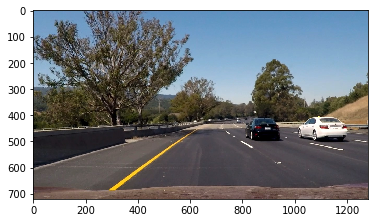

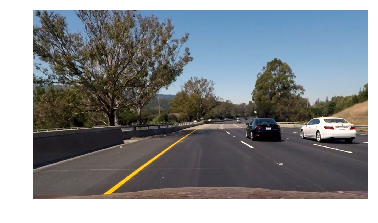

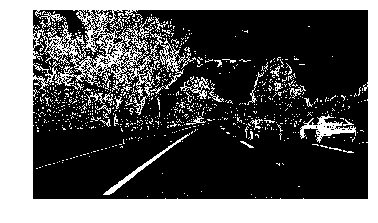

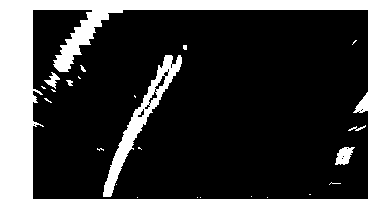

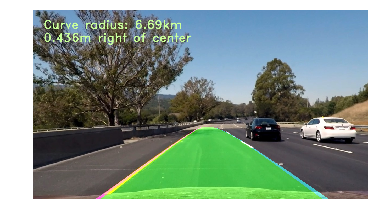

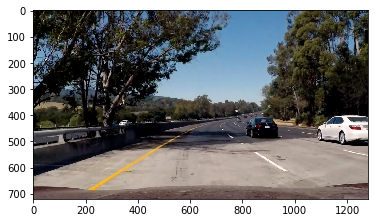

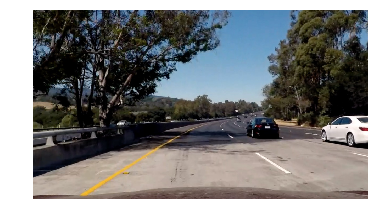

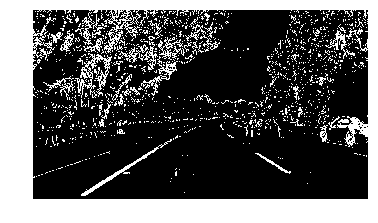

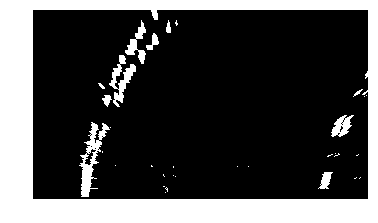

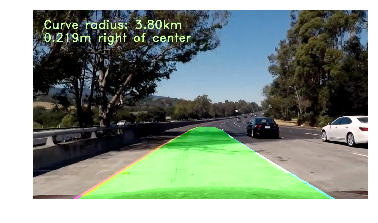

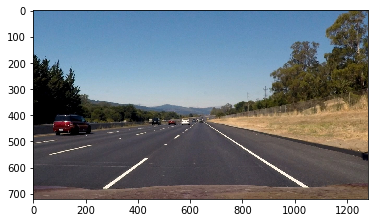

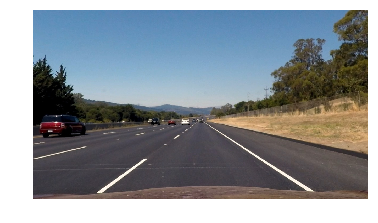

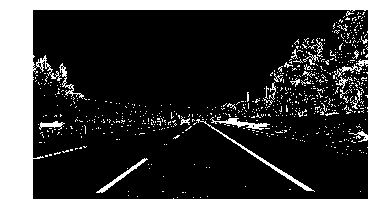

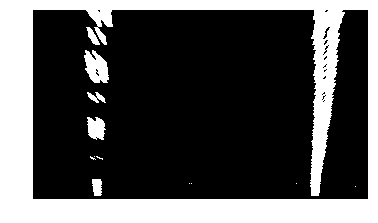

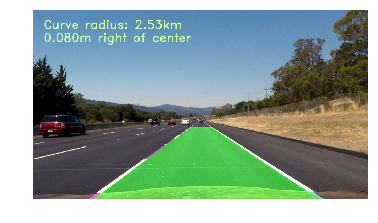

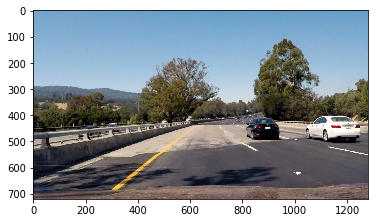

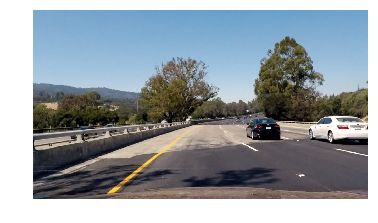

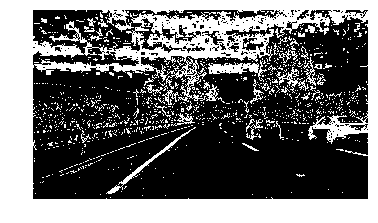

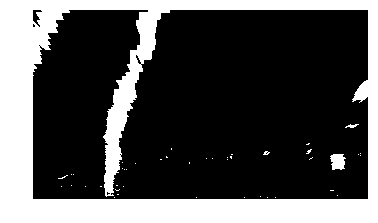

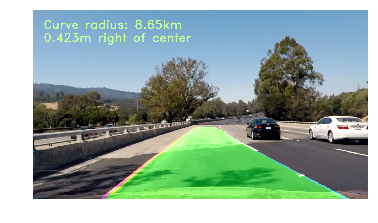

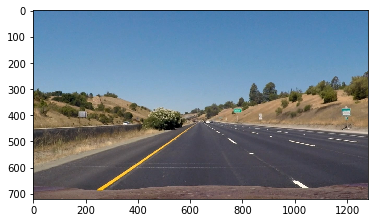

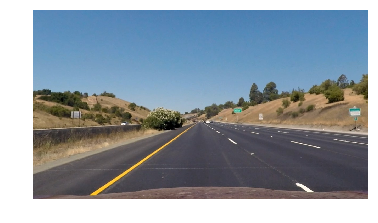

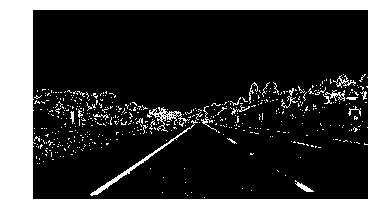

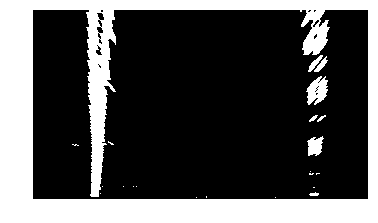

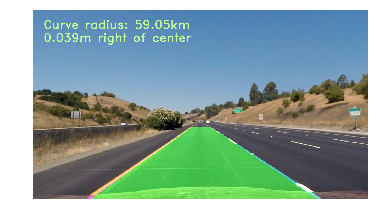

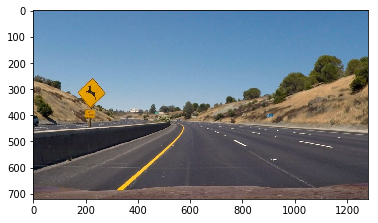

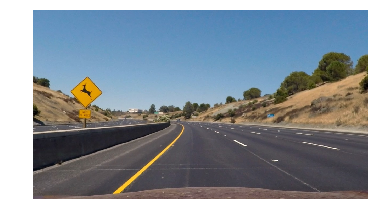

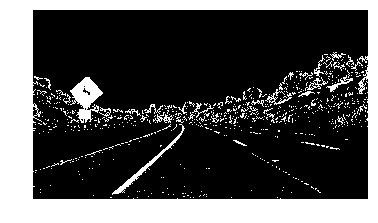

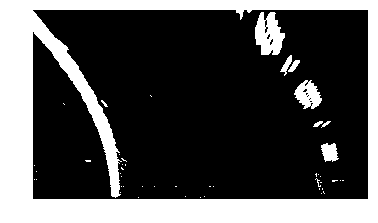

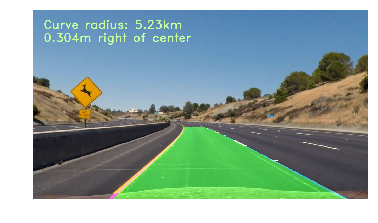

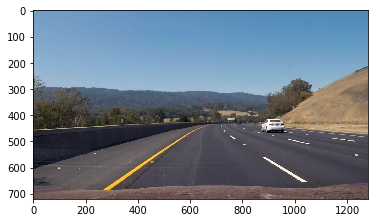

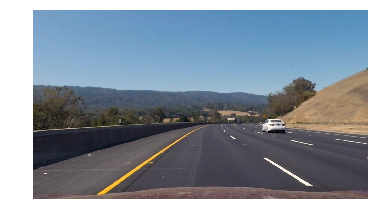

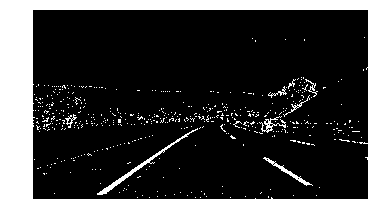

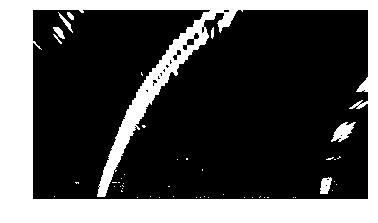

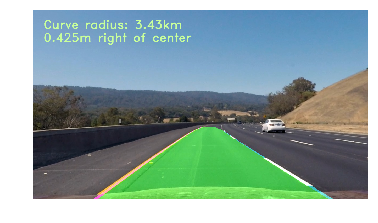

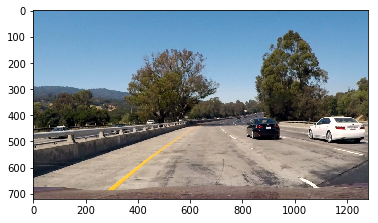

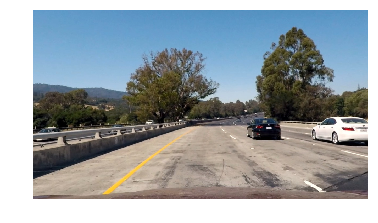

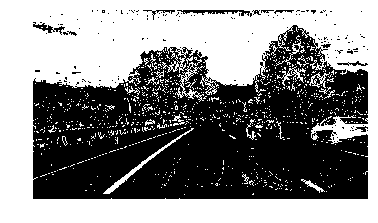

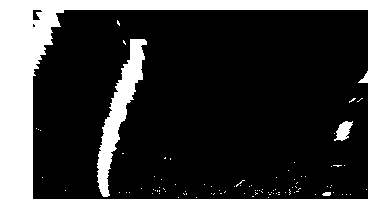

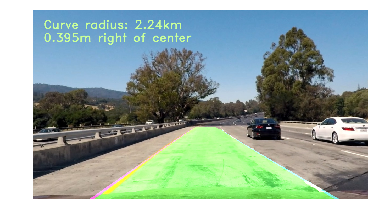

In [27]:
image_fold = 'test_images'
for file_name in os.listdir(image_fold):
    file_loc = image_fold + '/' + file_name
    img = mpimg.imread(file_loc)
    plt.figure(frameon=False)
    plt.imshow(img)
#     file = split
    result = pipeline(img, file_name)
    plt.figure(frameon=False)
    plt.axis('off')
    plt.imshow(result)
#     plt.axis('off')
    folder = 'output_images/'
    plt.savefig(folder + 'final_'+file_name, bbox_inches='tight', pad_inches=0)

In [12]:
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:59<00:00,  2.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 7min 19s, sys: 13.4 s, total: 7min 32s
Wall time: 7min


In [14]:
video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')#.subclip(10,12)
#video_input2.save_frame("challenge01.jpeg", t=0.25) # saves the frame at time = 0.25s
processed_video = video_input2.fl_image(pipeline)
%time processed_video.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:23<00:00,  4.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 31s, sys: 5.47 s, total: 1min 37s
Wall time: 1min 24s
